In [213]:
import warnings
warnings.filterwarnings('ignore')

import torch 
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import DataLoader, Dataset

from sklearn.datasets import load_breast_cancer
from sklearn.manifold import TSNE
from sklearn.metrics import mean_squared_error

from tqdm import tqdm_notebook

import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D
%matplotlib inline

In [188]:
data = load_breast_cancer()

In [189]:
train = data.data[:544]
test = data.data[544:]

In [190]:
actual = test.copy()

In [191]:
train.shape, test.shape

((544, 30), (25, 30))

### Make Dataset & DataLoader

In [192]:
class DATA(Dataset) :
    
    def __init__(self, inputs) :
        
        self.X = torch.tensor(inputs, dtype = torch.float)
        
    def __len__(self) :
        
        return len(self.X)
    
    def __getitem__(self, idx) :
        
        X_batch = self.X[idx]
        
        return X_batch

In [193]:
train = DATA(train)
test = DATA(test)

In [194]:
tr_loader = DataLoader(train, batch_size = 16, drop_last = True, shuffle = True)
te_loader = DataLoader(test, batch_size = 16, drop_last = False, shuffle = False)

***
## Build Model

In [195]:
class AutoEncoder(nn.Module) :
    
    def __init__(self) :
        
        super(AutoEncoder, self).__init__()
        
        ### Encoder
        self.encoder = nn.Sequential(
        nn.Linear(30, 64),
        nn.LeakyReLU(),
        nn.Linear(64, 16),
        nn.LeakyReLU(),
        nn.Linear(16, 8)
        )
        
        ### Decoder
        self. decoder = nn.Sequential(
        nn.Linear(8, 16),
        nn.LeakyReLU(),
        nn.Linear(16, 64),
        nn.LeakyReLU(),
        nn.Linear(64, 30)
        )
        
    def forward(self, x) :
        
        encoded = self.encoder(x)
        decoded = self.decoder(encoded)
        
        return encoded, decoded

In [196]:
AE = AutoEncoder().to('cpu')

In [197]:
AE

AutoEncoder(
  (encoder): Sequential(
    (0): Linear(in_features=30, out_features=64, bias=True)
    (1): LeakyReLU(negative_slope=0.01)
    (2): Linear(in_features=64, out_features=16, bias=True)
    (3): LeakyReLU(negative_slope=0.01)
    (4): Linear(in_features=16, out_features=8, bias=True)
  )
  (decoder): Sequential(
    (0): Linear(in_features=8, out_features=16, bias=True)
    (1): LeakyReLU(negative_slope=0.01)
    (2): Linear(in_features=16, out_features=64, bias=True)
    (3): LeakyReLU(negative_slope=0.01)
    (4): Linear(in_features=64, out_features=30, bias=True)
  )
)

### Setting Optimizer & Loss Function

In [198]:
optimizer = optim.Adam(AE.parameters(), lr = 0.002)

In [199]:
criterion = nn.L1Loss()

### Custom Function For Fitting Model

In [200]:
def train(num_epochs, model, tr_loader, te_loader, optimizer) :
    for epoch in tqdm_notebook(range(num_epochs)) :
        
        model.train()
        tr_losses = 0
        
        for xx in tr_loader :

            optimizer.zero_grad()
            xx = xx.to('cpu')
            _, decoded = model(xx)

            loss = criterion(decoded, xx)
            loss.backward()
            optimizer.step()
            tr_losses += loss.item() / len(tr_loader)
        
        with torch.no_grad() :
            te_losses = 0
            model.eval()
            
            for xx in te_loader :
                
                _, decoded = model(xx)
                loss = criterion(decoded, xx)
                te_losses += loss.item() / len(te_loader)
        print(f"{epoch + 1} Epoch Train Loss : {round(tr_losses, 4)} Test Loss : {round(te_losses, 4)}")
    return model

In [201]:
best_model = train(40, AE, tr_loader, te_loader, optimizer)

  0%|          | 0/40 [00:00<?, ?it/s]

1 Epoch Train Loss : 60.138 Test Loss : 51.7052
2 Epoch Train Loss : 35.3039 Test Loss : 11.4739
3 Epoch Train Loss : 8.8717 Test Loss : 6.9837
4 Epoch Train Loss : 7.0198 Test Loss : 5.9755
5 Epoch Train Loss : 6.763 Test Loss : 5.9391
6 Epoch Train Loss : 6.6044 Test Loss : 5.7141
7 Epoch Train Loss : 6.473 Test Loss : 5.6641
8 Epoch Train Loss : 6.3404 Test Loss : 5.6174
9 Epoch Train Loss : 6.4002 Test Loss : 5.6852
10 Epoch Train Loss : 6.255 Test Loss : 5.4208
11 Epoch Train Loss : 6.1083 Test Loss : 5.3495
12 Epoch Train Loss : 6.2463 Test Loss : 5.7091
13 Epoch Train Loss : 6.17 Test Loss : 5.5019
14 Epoch Train Loss : 5.8467 Test Loss : 4.6835
15 Epoch Train Loss : 4.9084 Test Loss : 2.9067
16 Epoch Train Loss : 3.8711 Test Loss : 3.1481
17 Epoch Train Loss : 4.0049 Test Loss : 4.544
18 Epoch Train Loss : 3.9165 Test Loss : 3.4345
19 Epoch Train Loss : 3.6237 Test Loss : 4.0049
20 Epoch Train Loss : 3.4238 Test Loss : 3.1532
21 Epoch Train Loss : 3.3058 Test Loss : 3.1662
22 E

### Make Decoded Using Best Model

In [ ]:
with torch.no_grad() :
    new_x = torch.zeros((0, 30))
    latent_vectors = torch.zeros((0, 8))
    best_model.eval()

    for xx in te_loader :

        encoded, decoded = best_model(xx)
        new_x = torch.cat((new_x, decoded), 0)
        latent_vectors = torch.cat((latent_vectors, encoded), 0)

- Get RMSE

In [204]:
mean_squared_error(actual, new_x, squared = True) ** 0.5

7.334010367387824

***
## Plotting Latent Space
- 3dims

In [208]:
tsne = TSNE(n_components = 3, random_state = 42)

In [212]:
tsne_result = tsne.fit_transform(latent_vectors.numpy())

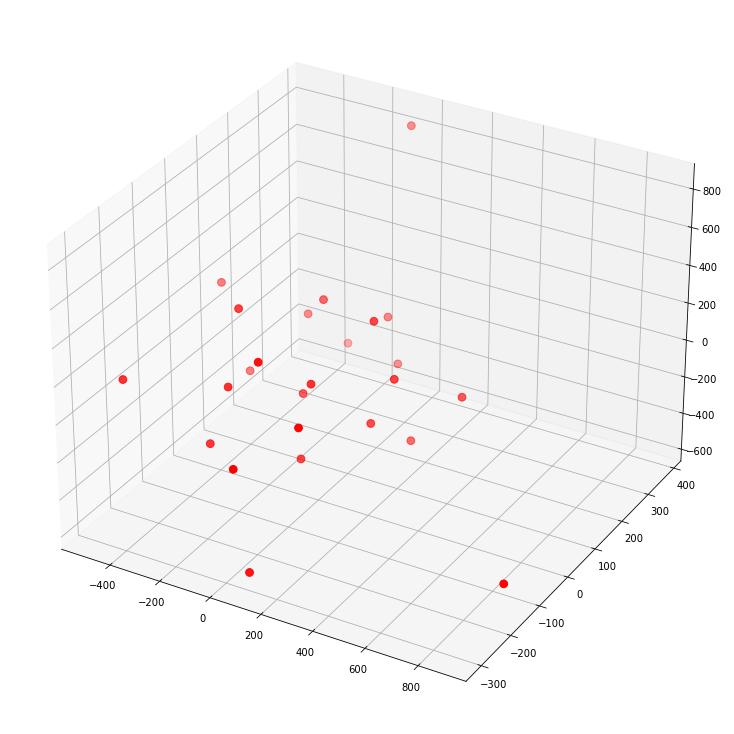

In [219]:
fig = plt.figure(figsize = (12, 10))
ax = Axes3D(fig)

x = tsne_result[:, 0]
y = tsne_result[:, 1]
z = tsne_result[:, 2]

ax.scatter(x, y, z, s = 60, color = 'r')
plt.show()